## Load Packages

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy import stats
import math
import bayesflow as bf
import numba as nb
import random
from scipy.stats import truncnorm
import pandas as pd
from pathlib import Path
import ipynbname
RNG = np.random.default_rng(2023)

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32, xoroshiro128p_normal_float32

import logging
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

print(tf.config.list_physical_devices('GPU'))

from tensorflow.python.platform import build_info as tf_build_info
print("cudnn_version",tf_build_info.build_info['cudnn_version'])
print("cuda_version",tf_build_info.build_info['cuda_version'])

2024-11-25 21:12:10.704130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 21:12:10.704164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 21:12:10.705419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 21:12:10.712484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 21:12:12.059843: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cudnn_version 8
cuda_version 12.2


## Get file path

In [ ]:
notebook_path = Path(ipynbname.path()).resolve().parent
root_dir = notebook_path.parent
#print(root_dir)

## Checkpoint

In [2]:
checkpoint_path_real_data_problem_standard =  root_dir/"network/robust"

## Define DDM

In [3]:
#from numba, compile the function for gpu
@cuda.jit
def cuda_diffusion_trial(rng_states, out_rt, out_resp, in_v, in_a, in_z, in_ndt, dt, max_steps, num_threads):
    """Simulates a trial from the diffusion model."""
    #does that mean it simulates a number of thread_id trials in parallel
    #A CUDA thread is the smallest unit of execution on the GPU.
    thread_id = cuda.grid(1)

    #check ensures that only the necessary threads are actively working on the task
    if (thread_id < num_threads):
        v = in_v[thread_id]
        a = in_a[thread_id]
        z = in_z[thread_id]
        ndt = in_ndt[thread_id]
        
        n_steps = 0
        x = a * z
        mu = v * dt
        sigma = math.sqrt(dt)

        # Simulate a single DM path
        for n_steps in range(max_steps):
            # DDM equation
            # xoroshiro128p_normal_float32(rng_states, thread_id) is generating a random number following a normal distribution
            #rng_states: This parameter represents the state of the random number generator for each thread
            x += mu + sigma * xoroshiro128p_normal_float32(rng_states, thread_id)
            # Stop when out of bounds
            if x <= 0.0 or x >= a:
                break

        rt = float(n_steps) * dt

        if x > 0:
            resp = 1.
        else:
            resp = 0.  

        out_rt[thread_id] = np.log(rt+ndt)
        out_resp[thread_id] = resp


## Define Hyperprior and Prior


In [5]:
#################################################define prior
##############################################################

#RNG = np.random.default_rng(2023)
def diffusion_prior():
    "Generates a random draw from the joint prior distribution."
    #normal distribution for the drift rates
    drifts_1 = RNG.uniform(-7,7)
    drifts_2 = RNG.uniform(-7,7)
    drifts_3 = RNG.uniform(-7,7)
    drifts_4 = RNG.uniform(-7,7)
    drifts_5 = RNG.uniform(-7,7)
    threshold = RNG.uniform(0.5,5)
    ndt = RNG.gamma(1.5, 1 / 5.0)
    z = RNG.uniform(0.01,0.99)
    return np.hstack((drifts_1, drifts_2, drifts_3, drifts_4, drifts_5, threshold, z, ndt))

PARAM_NAMES = [
    "Drift rate 1",
    "Drift rate 2",
    "Drift rate 3",
    "Drift rate 4",
    "Drift rate 5",
    "Boundary separation",
    "Response bias",
    "Non-decision time" 
]

prior = bf.simulation.Prior(prior_fun=diffusion_prior, param_names=PARAM_NAMES)

#################################################context
########################################################

MIN_OBS = 1000
MAX_OBS = 5000
NUM_CONDITIONS=5

# def random_num_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
#     """Draws a random number of observations for all simulations in a batch."""

#     return 1000

def random_num_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
#   """Draws a random number of observations for all simulations in a batch."""

   return RNG.integers(low=min_obs, high=max_obs + 1)

def generate_condition_matrix(num_obs, num_conditions=NUM_CONDITIONS):
    """Generates a random design matrix with approximate counts of conditions."""
    # Calculate approximate counts with some randomness
    counts = np.random.multinomial(num_obs, [1/num_conditions] * num_conditions)
    
    # Create the condition array
    condition = np.concatenate([np.full(count, i) for i, count in enumerate(counts)])
    
    # Shuffle the condition array to randomize order
    np.random.shuffle(condition)
    
    return condition


context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_num_obs,
    batchable_context_fun=generate_condition_matrix,
    use_non_batchable_for_batchable=True
)

   

## Define the Study Design Information


## Combine the Design Information and the Trial-wise Simulator

In [6]:
#rng_states = create_xoroshiro128p_states(num_threads, seed)
rng_states = create_xoroshiro128p_states(1000*1000*32, seed=5)

#simulates the parameters
@nb.njit
def cuda_convert_matrix_to(theta, design_matrix):
    batch_size = theta.shape[0]
    num_obs = len(design_matrix[0])

    #Setting threads_per_block = 32 is a common choice in CUDA programming due to the GPU’s hardware architecture
    threads_per_block = 32
    total_threads = batch_size * num_obs
    blocks = math.ceil(total_threads / threads_per_block)
    
    in_v = np.zeros(batch_size  * num_obs, dtype=np.float32)
    in_a = np.zeros(batch_size * num_obs, dtype=np.float32)
    in_z = np.zeros(batch_size * num_obs, dtype=np.float32)
    in_ndt = np.zeros(batch_size * num_obs, dtype=np.float32)
    
    for i in range(batch_size): # loop over data sets
        theta_i = theta[i]
        for k in range(num_obs): # loop over observations
            index = design_matrix[i][k]
            #simulated data as a 4D tensor of shape (num_datasets, num_participants, num_observations, num_variables)
            in_index = i  * num_obs + k
            in_v[in_index] = theta_i[index]
            in_a[in_index] = theta_i[-3]
            in_z[in_index] = theta_i[-2]
            in_ndt[in_index] = theta_i[-1]

    return in_v, in_a, in_z, in_ndt


#reorgnized the data format
@nb.njit
def cuda_convert_matrix_from(theta, design_matrix, out_rt, out_resp):
    batch_size = theta.shape[0]
    num_obs = len(design_matrix[0])

    out = np.zeros((batch_size,num_obs, 2), dtype=np.float32)

    for i in range(batch_size): # loop over data sets
        theta_i = theta[i]
        for k in range(num_obs): # loop over observations
            #simulated data as a 4D tensor of shape (num_datasets, num_participants, num_observations, num_variables)
            out_index = i * num_obs + k
            out[i, k, :] = np.array([out_rt[out_index], out_resp[out_index]], dtype=np.float32)

    return out


#simulate the trials
def cuda_hierarchical_simulator_robust(theta, design_matrix, rng=None, *args):
   
    batch_size = theta.shape[0]
    num_obs = len(design_matrix[0])

    threads_per_block = 32
    total_threads = batch_size* num_obs
    blocks = math.ceil(total_threads / threads_per_block)
    #rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=random.randint(1,65536))
    global rng_states
    
    out_resp = np.zeros(batch_size * num_obs, dtype=np.float32)
    out_rt = np.zeros(batch_size  * num_obs, dtype=np.float32)
    
    in_v, in_a, in_z, in_ndt = cuda_convert_matrix_to(theta, design_matrix)

    cuda_diffusion_trial[blocks, threads_per_block](rng_states, out_rt, out_resp, in_v, in_a, in_z, in_ndt, 1e-3, 15000, total_threads)
    
    out = cuda_convert_matrix_from(theta, design_matrix, out_rt, out_resp)
    CC=np.random.standard_t(df=1,size=(batch_size, num_obs))
    X=np.random.binomial(n=1,p=.1,size=(batch_size, num_obs))
    out[:, :, 0] = (1-X)*out[:, :, 0] + (X)*np.log(np.abs(CC))
    out[:, :, 1] = (1-X)*out[:, :, 1] + (X)*np.random.binomial(n=1,p=0.5,size=(batch_size, num_obs))
    
    return out


   

In [8]:
simulator_robust = bf.simulation.Simulator(batch_simulator_fun=cuda_hierarchical_simulator_robust, context_generator=context_gen)
model_robust = bf.simulation.GenerativeModel(prior=prior, simulator=simulator_robust, name="Hierarchical DDM")

/data/leuven/361/vsc36114/miniconda3/envs/science/lib/python3.11/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
INFO:root:Performing 2 pilot runs with the Hierarchical DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2300, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: ()
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!


## Configurator

In [9]:
from tensorflow.keras.utils import to_categorical

#a configurator extracts the results of the generative model to a format
#that the neural network would like
#transformation of the data/ parameters
#Try this with a example simulation
def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["sim_data"]

    # Convert list of condition indicators to a 2D array and add a
    # trailing dimension of 1, so shape becomes (batch_size, num_obs, 1)
    # We need this in order to easily concatenate the context with the data
    context = np.array(forward_dict["sim_batchable_context"])[..., None]

    # One-hot encoding of integer choices
    categorical_resp = to_categorical(data[:, :, 1], num_classes=2)

    # Concatenate rt, resp, context
    out_dict["summary_conditions"] = np.c_[data[:, :, :1], categorical_resp, context].astype(np.float32)

    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = forward_dict["sim_non_batchable_context"] * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    # Get data generating parameters
    out_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)


    return out_dict



## Networks

In [11]:
from tensorflow_probability import distributions as tfd
import tensorflow as tf
#SetTransformer() is a permutation invariant network
#input_dim = how many dimensions the configured data would have
#here we have a RT, dummy coded variable for the two choices (one or two?), the context dummy
summary_net_real_data_problem_robust = bf.networks.SetTransformer(input_dim=4, summary_dim=15, name="ddm_summary")

#we are turning off the kernel and dropout regularization for the networks 
#since we don’t need these for online training
inference_net_real_data_problem_robust = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_design="interleaved",
    name="ddm_inference",
)

amortizer_real_data_problem_robust= bf.amortizers.AmortizedPosterior(inference_net_real_data_problem_robust, summary_net_real_data_problem_robust, name="ddm_amortizer_c")


trainer_real_data_problem_robust = bf.trainers.Trainer(
    generative_model=model_robust, amortizer=amortizer_real_data_problem_robust, configurator=configurator,
    checkpoint_path = checkpoint_path_real_data_problem_robust
)
amortizer_real_data_problem_robust.summary()


INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
/data/leuven/361/vsc36114/miniconda3/envs/science/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 71 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
INFO:root:Done.


Model: "ddm_amortizer_c"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ddm_inference (InvertibleN  multiple                  503688    
 etwork)                                                         
                                                                 
 ddm_summary (SetTransforme  multiple                  48668     
 r)                                                              
                                                                 
Total params: 552356 (2.11 MB)
Trainable params: 552260 (2.11 MB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


## Train the Model

In [ ]:
#history =trainer_real_data_problem_robust.train_online(epochs=250, iterations_per_epoch=1000, batch_size=32)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]2024-11-25 21:13:27.673270: I external/local_xla/xla/service/service.cc:168] XLA service 0x153dc6820150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-25 21:13:27.673299: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-SXM2-16GB, Compute Capability 6.0
2024-11-25 21:13:27.677966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 21:13:27.697485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1732565607.766311   43381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Training epoch 8:  18%|█▊        | 176/1000 [00:24<01:51,  7.38it/s, Epoch: 8, Iter: 176,Loss: 7.996,W.Decay: 0.107,Avg.Loss: 7.987,Avg.W.Dec

Estimation will be performed on data sets with 4506 simulated trials.


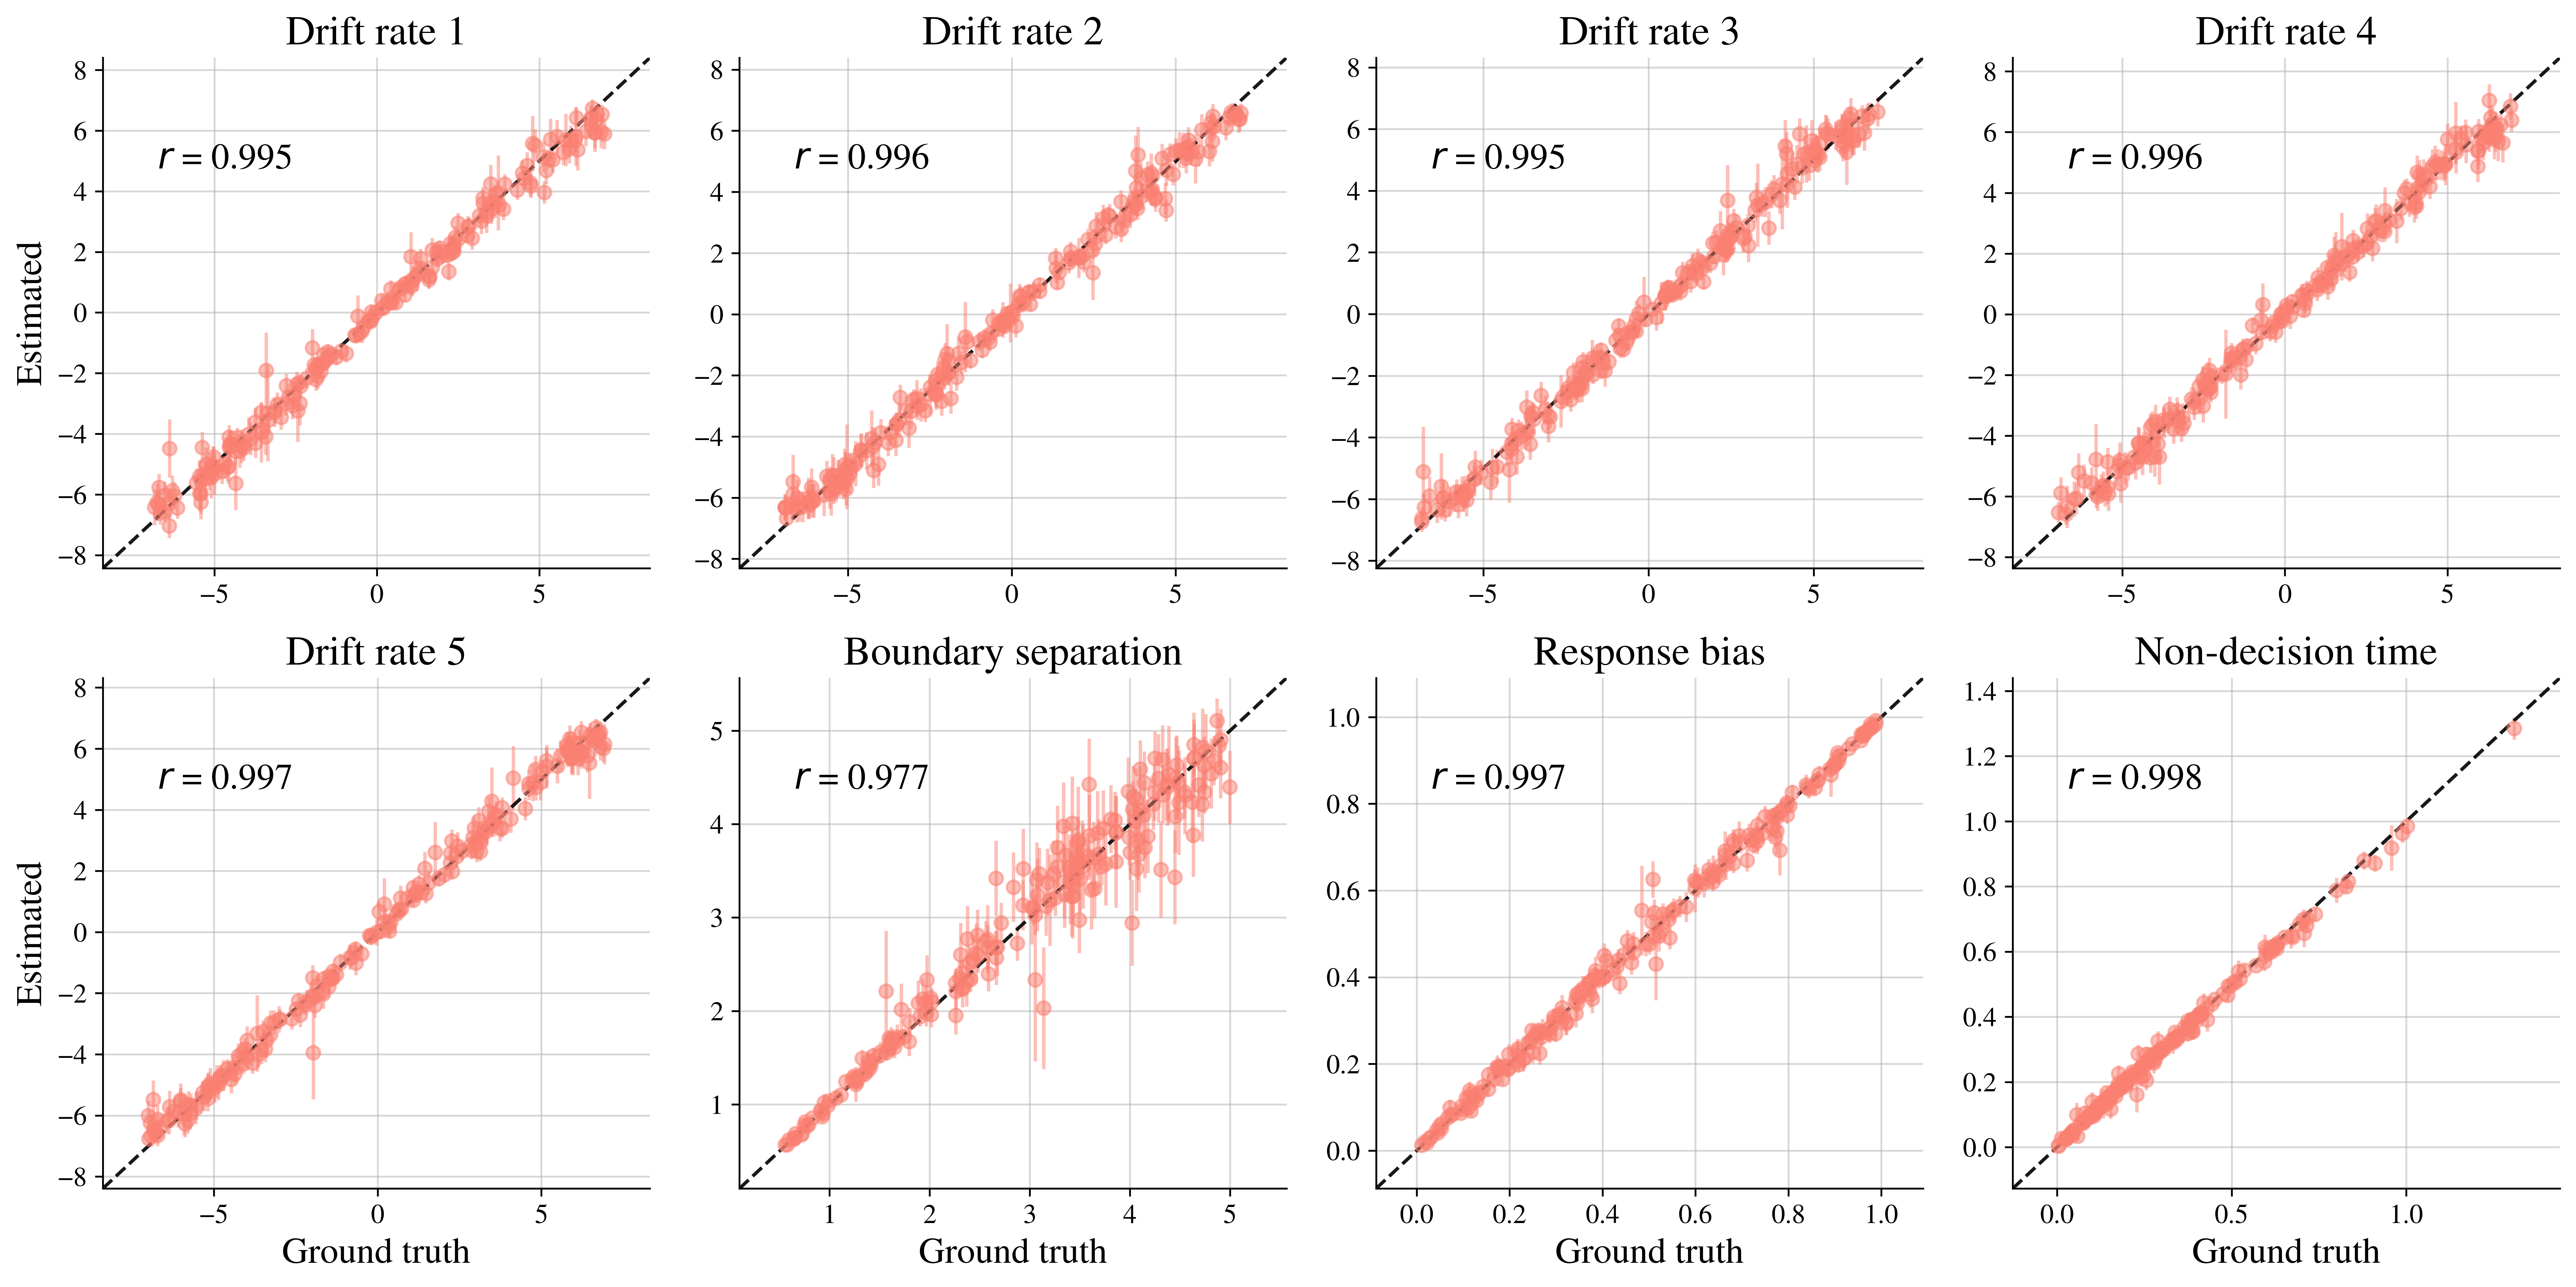

In [12]:
# Generate some validation data
validation_sims = configurator(model_robust(batch_size=200))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"] 

print(
    f"Estimation will be performed on data sets with {validation_sims['summary_conditions'].shape[1]} simulated trials."
)

# Generate 100 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer_real_data_problem_robust.sample(validation_sims, n_samples=1000)
post_samples.shape

plt.rcParams['font.family'] = 'Nimbus Roman'
f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std,color='salmon',add_r2=False)
f.set_dpi(600)